In [ ]:
import shap
import pickle
# Store the best tuned model
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DateTime     10000 non-null  object 
 1   month        10000 non-null  int64  
 2   year         10000 non-null  int64  
 3   hour         10000 non-null  int64  
 4   Minutes      10000 non-null  float64
 5   Seconds      10000 non-null  float64
 6   Defect_Rate  10000 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


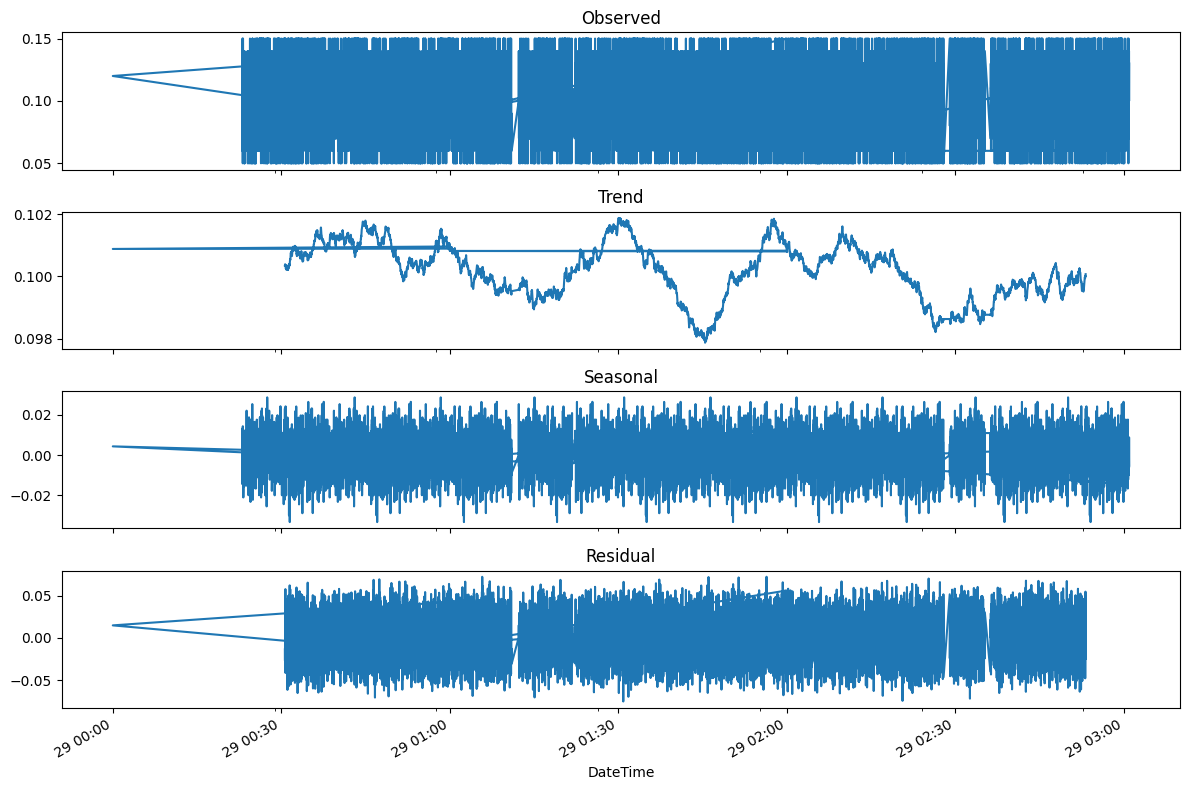

{'ADF Statistic': -99.96960281295289,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.4310041633725734,
  '5%': -2.861829101294412,
  '10%': -2.566923883481157}}

In [ ]:


# Load the provided dataset to inspect its structure and content
file_path = '../preprocessed_data/defect_rate_preprocessed.csv'
data = pd.read_csv(file_path)

# Display the first few rows and dataset information for analysis
data.head(), data.info()

# Convert DateTime to datetime type and set it as the index
data['DateTime'] = pd.to_datetime(data['DateTime'])
data.set_index('DateTime', inplace=True)

# Perform time series decomposition
decompose_result = seasonal_decompose(data['Defect_Rate'], model='additive', period=1_000)  # Assuming a seasonal period estimate

# Plot decomposition results
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decompose_result.observed.plot(ax=axes[0], title='Observed')
decompose_result.trend.plot(ax=axes[1], title='Trend')
decompose_result.seasonal.plot(ax=axes[2], title='Seasonal')
decompose_result.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

# Perform the ADF test to check for stationarity
adf_result = adfuller(data['Defect_Rate'])

# Output the ADF test results
adf_summary = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Critical Values": adf_result[4]
}
adf_summary


In [ ]:


# Resample the data to 1-minute intervals
data_resampled = data['Defect_Rate'].resample('1T').mean()

# Check if resampling worked correctly and display the new data structure
data_resampled.head(), data_resampled.info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 181 entries, 2024-08-29 00:00:00 to 2024-08-29 03:00:00
Freq: min
Series name: Defect_Rate
Non-Null Count  Dtype  
--------------  -----  
158 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


C:\Users\pawan\AppData\Local\Temp\ipykernel_10916\1738474747.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_resampled = data['Defect_Rate'].resample('1T').mean()


(DateTime
 2024-08-29 00:00:00    0.12
 2024-08-29 00:01:00     NaN
 2024-08-29 00:02:00     NaN
 2024-08-29 00:03:00     NaN
 2024-08-29 00:04:00     NaN
 Freq: min, Name: Defect_Rate, dtype: float64,
 None)

In [3]:
# Handle missing values by forward-filling, then backward-filling as needed
data_resampled = data_resampled.ffill().bfill()

# Verify the missing values are handled
data_resampled.isnull().sum()


0